# Camera

### Imaging a Point Cloud Using a Camera Consructed by Specifying Extrinsic and Intrinsic Parameters

In [8]:
import numpy as np
from plyfile import PlyData, PlyElement
import scipy
import matplotlib.pyplot as plt
import cv2

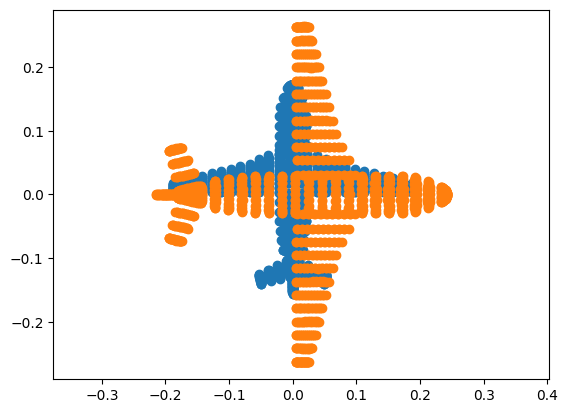

In [26]:
pcd =  PlyData.read(r"images/airplane.ply") # Read the point cloud
points = np.concatenate((pcd['vertex']['x'].reshape(1,-1), pcd['vertex']['y'].reshape(1,-1), pcd['vertex']['z'].reshape(1,-1)), axis=0)
points = points - np.mean(points, axis = 1).reshape(3,1) # Center the points

ones = np.ones((1, points.shape[1]))
points = np.concatenate((points, ones), axis=0) # Add the fourth dimension for homogenous coordinates


P = np.array([[1., 0., 0., 0.], 
              [0., 1., 0., 0.],
              [0., 0., 1., 0.]])

# Rotation matrix R is an orthonormal marix
R = np.array([[1., 0., 0.], 
              [0., 1., 0.],
              [0., 0., 1.]])
K = np.array([[1., 0., 0.],
              [0., 1., 0.],
              [0., 0., 1.]])
t = np.array([[0.],
              [0.],
              [-4000.]])
P1 = np.matmul(K, np.concatenate((R, t), axis=1))# P = K[R|t] = K[R|-RC]

R = np.array([[0., 0.7, 0.], 
              [0.7, 0., 0.],
              [0., 0., 0.7]])
K = np.array([[2., 0., 0.],
              [0., 2., 0.],
              [0., 0., 1.]])
P2 = np.matmul(K, np.concatenate((R, t), axis=1))

fig, ax = plt.subplots(1,1, sharex=True, sharey=True)
transfromed = P1 @ points
transfromed = transfromed/transfromed[2,:]
ax.scatter(transfromed[0,:], transfromed[1,:])

transfromed = P2 @ points
transfromed = transfromed/transfromed[2,:]
ax.scatter(transfromed[0,:], transfromed[1,:])
ax.axis('equal')
plt.show()

Text(0.5, 0, 'z')

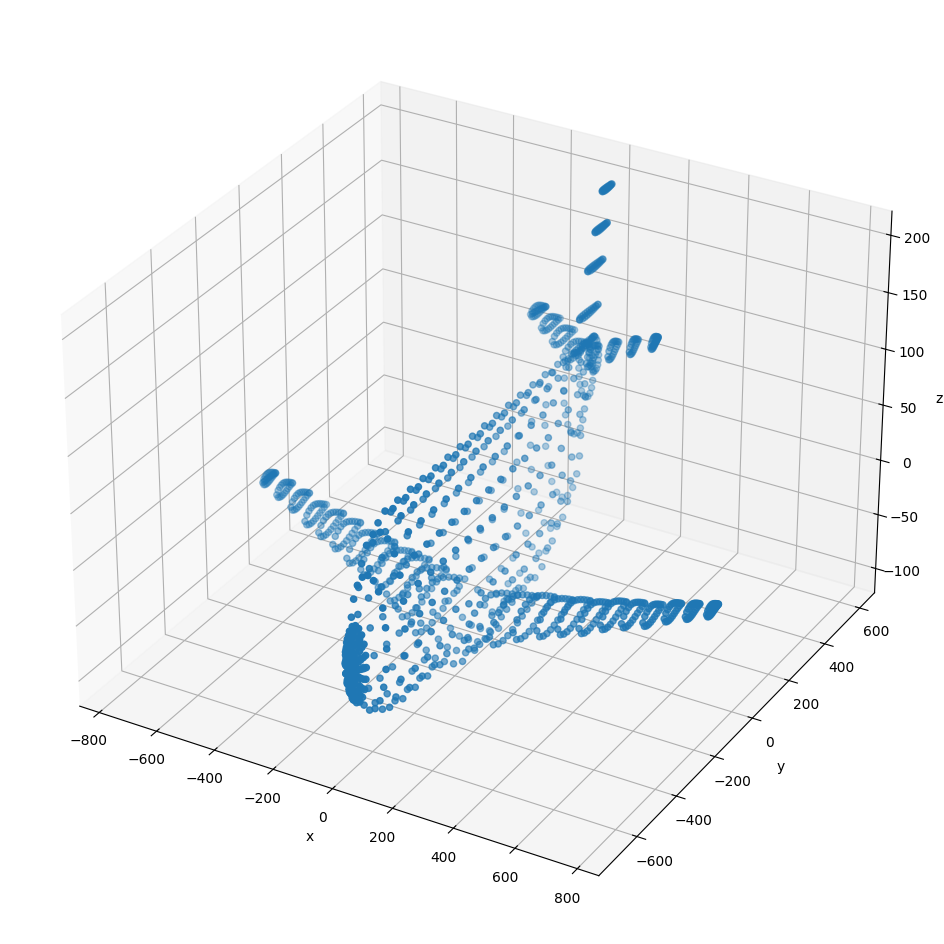

In [27]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(points[0,:], points[1,:], points[2,:])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [28]:
np.set_printoptions(precision=4, suppress=True)
print('P1\n', P1)
print('P2\n', P2)

P1
 [[    1.     0.     0.     0.]
 [    0.     1.     0.     0.]
 [    0.     0.     1. -4000.]]
P2
 [[    0.      1.4     0.      0. ]
 [    1.4     0.      0.      0. ]
 [    0.      0.      0.7 -4000. ]]


### Recovering K, R and C

In [29]:
# RQ Decomposition
# http://ksimek.github.io/2012/08/14/decompose/
def rq(M):
    ''' Here we do QR decomposition, but we want RQ decomposition
    so we do QR decomposition and then transpose the result'''
    Q, R = np.linalg.qr(np.flipud(M).T)
#     print(Q)
#     print(R)
    R = np.flipud(R.T)
    R = np.fliplr(R) 
    Q = Q.T;   
    Q = np.flipud(Q)
    return R, Q

In [31]:
M = P2[:, 0:3]
C = np.linalg.inv(M)@P1[:,3] # camera center in world coordinates
K, R = rq(M)

# make diagonal of K positive
T = np.diag(np.sign(np.diag(K)))

K = K @ T
R = T @ R # (T is its own inverse)
print(K)
print(R)

[[1.4 0.  0. ]
 [0.  1.4 0. ]
 [0.  0.  0.7]]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [32]:
# make diagonal of K positive
T = np.diag(np.sign(np.diag(K)))

K = K @ T
R = T @ R # (T is its own inverse)
print(K)
print(R)

[[1.4 0.  0. ]
 [0.  1.4 0. ]
 [0.  0.  0.7]]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [33]:
Phz = np.array(
    [[3.53553e+2, 3.39645e+2, 2.77744e+2, -1.44946e+6], 
     [-1.03528e+2, 2.33212e+1, 4.59607e+2, -6.32525e+5],
     [7.07107e-1, -3.53553e-1, 6.12372e-1, -9.18559e+2]])

In [34]:
M = Phz[:, 0:3]
C = -np.linalg.inv(M)@Phz[:,3] # camera center in world coordinates
K, R = rq(M)
# K, R = scipy.linalg.rq(M)

# make diagonal of K positive
T = np.diag(np.sign(np.diag(K)))

K = K @ T
R = T @ R # (T is its own inverse)
print(C)
print(K)
print(R)

# Checking again
P = K @ R @ np.concatenate((np.eye(3), -C.reshape(3,1)), axis=1)
print(P)

[1000.0007 2000.002  1500.0003]
[[468.1647  91.2251 300.    ]
 [  0.     427.2009 199.9999]
 [  0.       0.       1.    ]]
[[ 0.4138  0.9091  0.0471]
 [-0.5734  0.2201  0.7892]
 [ 0.7071 -0.3536  0.6124]]
[[     353.553       339.645       277.744  -1449460.    ]
 [    -103.528        23.3212      459.607   -632525.    ]
 [       0.7071       -0.3536        0.6124     -918.559 ]]


In [36]:
print(np.round(K, 2))
print(np.concatenate((np.eye(3), -C.reshape(3,1)), axis=1))

[[468.16  91.23 300.  ]
 [  0.   427.2  200.  ]
 [  0.     0.     1.  ]]
[[    1.         0.         0.     -1000.0007]
 [    0.         1.         0.     -2000.002 ]
 [    0.         0.         1.     -1500.0003]]


### Camera imaging

Consider a point on a sensor at $(\hat{x}, \hat{y})mm$ with pixel densities $m_x$ and $m_y$ pixels per mm. The pixel number is then given by 
$$ x = m_x \hat{x} $$
and 
$$ y = m_y \hat{y} $$ 
But the origin need not be in the center. It may be in one of the corners. Therefore, the coordinated become:
$$ x = m_x \hat{x} + x_0 $$
and 
$$y = m_y \hat{y} + y_0$$
But $\hat{x}$ and $\hat{y}$ are in the camera coordinate system and they can be written by:
$$\hat{x} = f \frac{X}{Z}$$
and
$$\hat{y} = f \frac{Y}{Z}$$
where $f$ is the focal length of the camera. Therefore, the pixel coordinates become:
$$x = m_x f \frac{X}{Z} + x_0$$
and
$$y = m_y f \frac{Y}{Z} + y_0$$
$f$, $x_o$ and $y_o$ are intrinsic parameters of the camera.

The homogenous 3D coordinate can be represented as:
$$\begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix} = \begin{bmatrix} \tilde{w}X \\ \tilde{w}Y \\ \tilde{w}Z \\ \tilde{w} \end{bmatrix}$$

Consider the previous equation. Any pixel coordinates $(u,v)$.

$$\begin{bmatrix} u \\ v \\ 1 \end{bmatrix} = \begin{bmatrix} Zu \\ Zv \\ Z \end{bmatrix} = \begin{bmatrix} fX + Zo_x \\ fY + Zo_y \\ Z \end{bmatrix} = \begin{bmatrix} f_x & 0 & o_x & 0 \\0 & f_y & o_y & 0 \\ 0 & 0 & 1 & 0 \end{bmatrix}. \begin{bmatrix}X \\ Y \\ Z \\ 1 \end{bmatrix}$$

The 3x4 matrix is the intrinsic matrix. The first 3x3 matrix is called the calibration matrix which is upper triangular.

Now we are done with mapping the 3d point in camera coordinates to a point in the matrix. Next we need to map the world coordinates to the camera coordinates. (3D to 3D). This can be done by the position of the camera coordinates with respect to the world coordintates. This is given by a rotation and translation matrix.
$$R = \begin{bmatrix} r_{11} & r_{12} & r_{13} \\ r_{21} & r_{22} & r_{23} \\ r_{31} & r_{32} & r_{33} \end{bmatrix}$$
The first row gives the direction of camera's x coordinates in the world, second row is for y and 3rd row is for z. The rotation matrix is an orthomormal matrix. We concatenate this with a translation matrix
$$t = \begin{bmatrix}t_x, t_y, t_z \end{bmatrix}$$

To do this in 1 matrix, we use homogenous coordinates
$$\begin{bmatrix} r_{11} & r_{12} & r_{13} & t_x \\ r_{21} & r_{22} & r_{23} & t_y \\ r_{31} & r_{32} & r_{33} & t_z \\ 0 & 0 & 0 & 1\end{bmatrix}\begin{bmatrix}X \\ Y \\ Z \\ 1 \end{bmatrix}$$

This matrix is called the extrinsic matrix.

If non homgenous coordinates are used,

$$ X_{cam} = R(X - C)$$

$$X_{cam} = \begin{bmatrix} r_{11} & r_{12} & r_{13} \\ r_{21} & r_{22} & r_{23} \\ r_{31} & r_{32} & r_{33} \end{bmatrix}\begin{bmatrix}X \\ Y \\ Z \end{bmatrix} + \begin{bmatrix} t_x \\ t_y \\ t_z \end{bmatrix}$$

where $C$ is the camera center in world coordinates. $t = -RC$

The camera projection matrix is given by:

$$ P = K[R | t]$$

where $K$ is the intrinsic matrix given by:

$$K = \begin{bmatrix} f_x & 0 & x_0 \\ 0 & f_y & y_0 \\ 0 & 0 & 1 \end{bmatrix}$$

### Camera Calibration

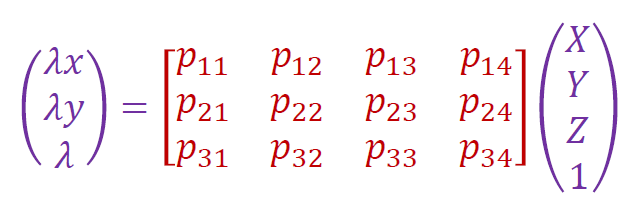

To calibrate we use a known distinctive pattern such as a checkerboard pattern.

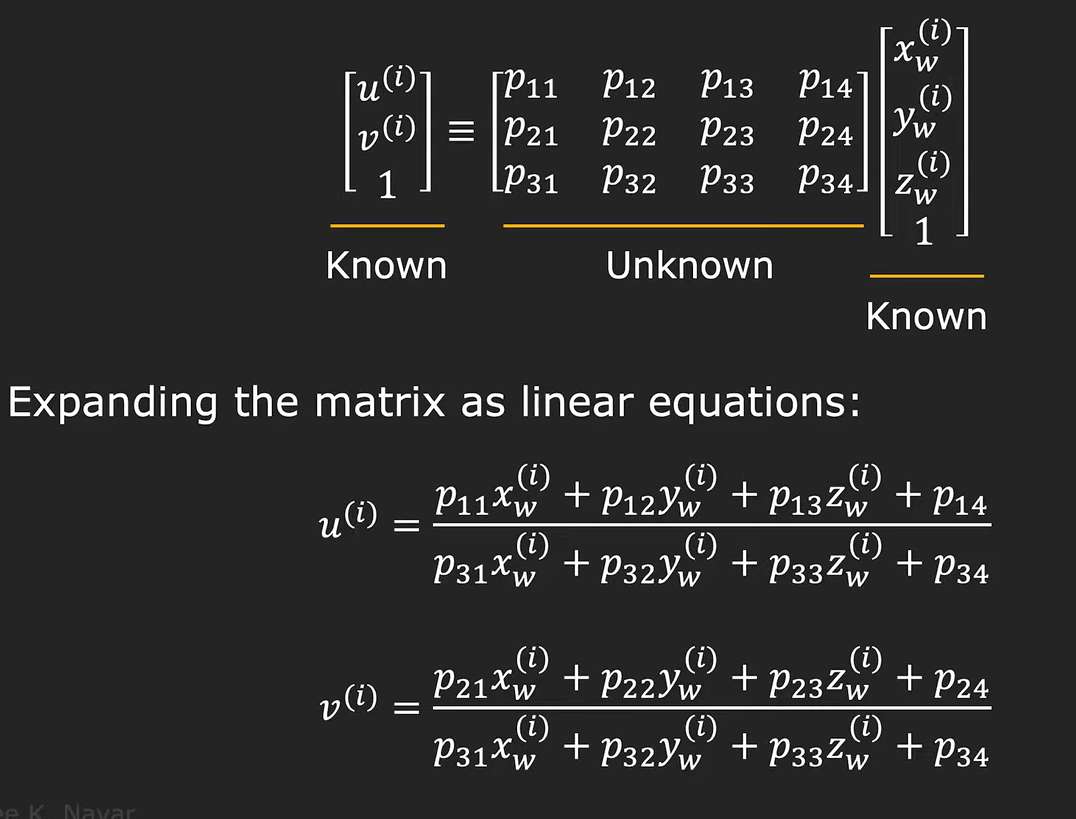

Scaling the projection matrix inplies scaling the world and the camera by the same factor and hence the scale can be arbitrary.

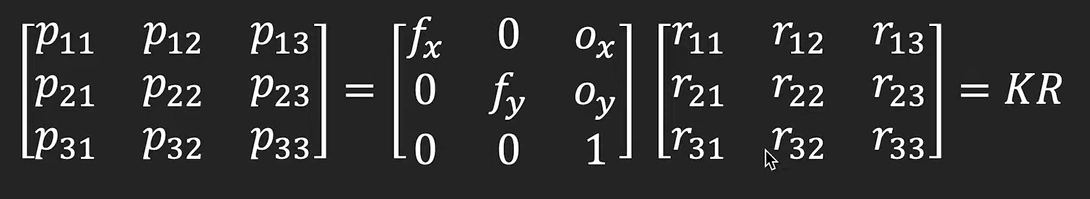

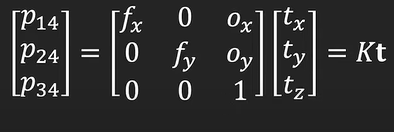

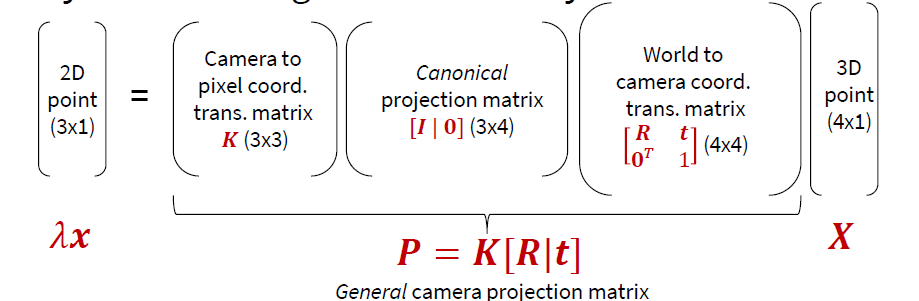

### Triangulation

The goal in triangulation is to find the 3D point that projects to the two points in two images. The 3D point is given by:

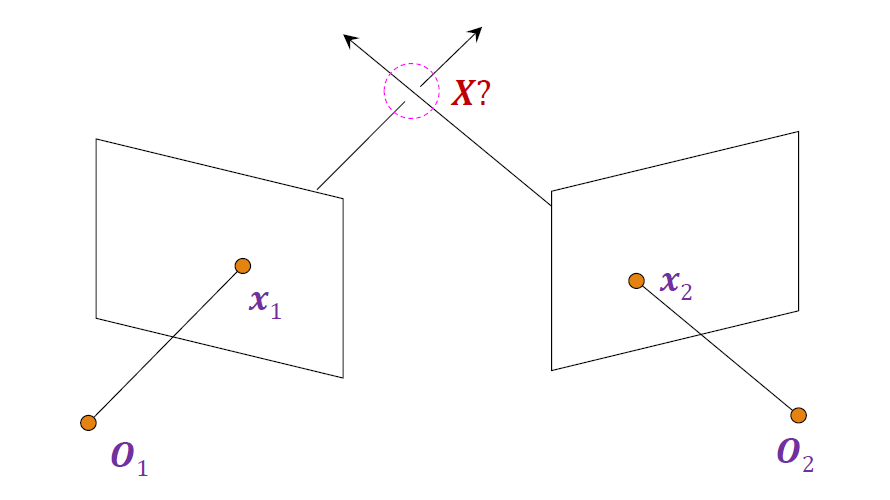

In 3D, the 2 rays may not intersect. Therefore, we obtain the shortest line between the 2 lines and consider the midpoint of such a line as $X$.

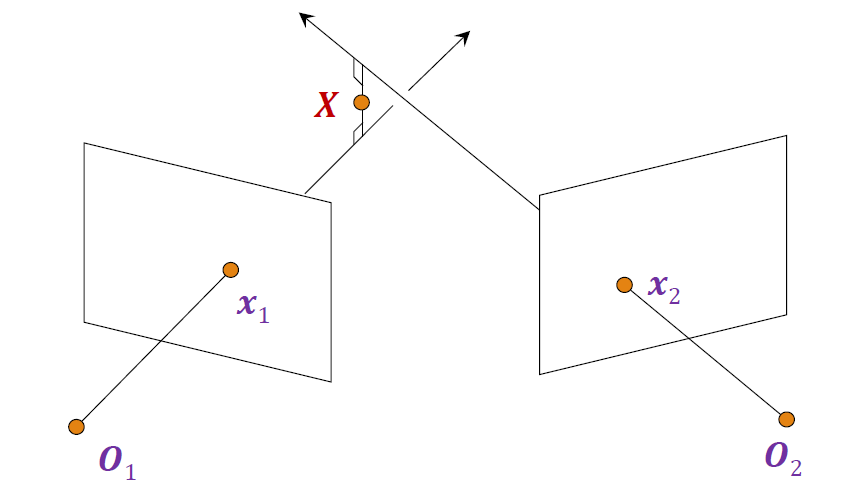

The goal is to minimize

$$||proj(P_1X) - x_1||^2_2 + ||proj(P_1X) - x_1||^2_2$$

Now, we have 2 camera matrices.

$\lambda_1x_1 = P_1X$ and $\lambda_2x_1 = P_2X$

Since vectors are parallel, the cross product is 0

$x_1 \times P_1X = 0$ and $x_2 \times P_2X = 0$

Rewriting cross product as a matrix multiplication:

$$\begin{bmatrix} 0 & -1 & y_1 \\ 1 & 0 & -x_1 \\ -y_1 & x_1 & 0 \end{bmatrix} \begin{bmatrix} P_1X \end{bmatrix} = 0$$

Here, $X$ and $x_1$ are known and $P_1$ is unknown. Therefore, we have 11 unknowns and 3 equations. Eachpoint gives 2 linearly independent equations. Therefore, we need atleast 6 points to solve this.

### Vanishing Points for camera calibration

Previously, for camera calibration, we required known points in 3D space. What if such known points are not available? In such a case, we use vanishing points. A vanishing point is the point where parallel lines appear to converge in an image. It may be finite (in the case where parallel lines are not parallel in the image) or infinite (in the case where parallel lines are parallel in the image). 

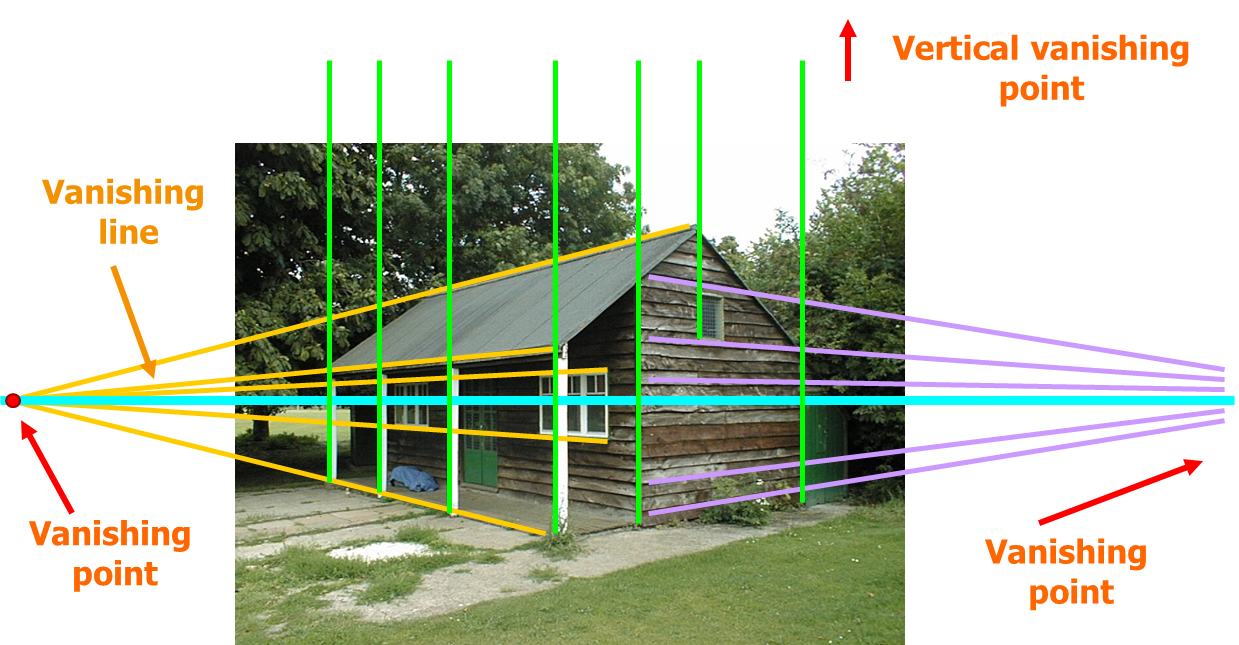

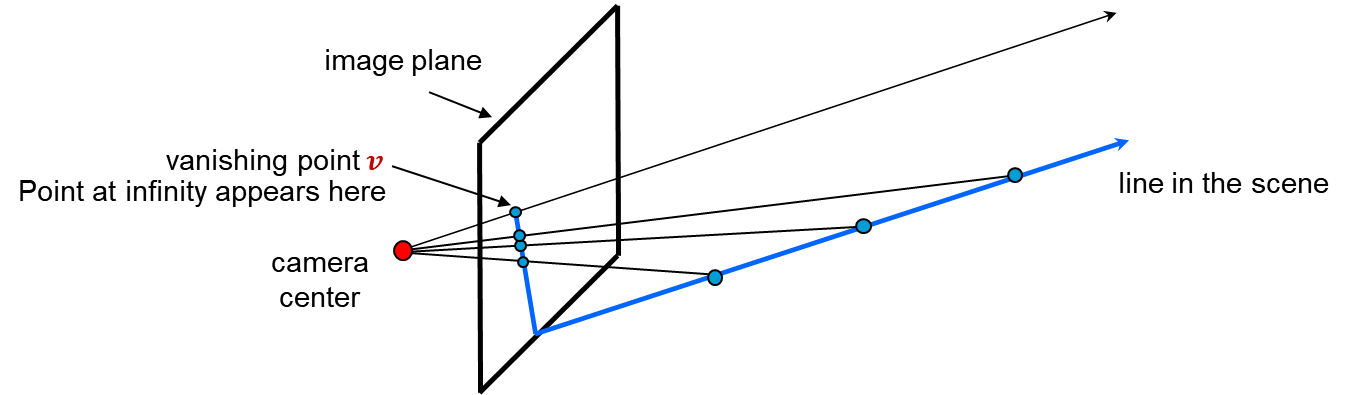

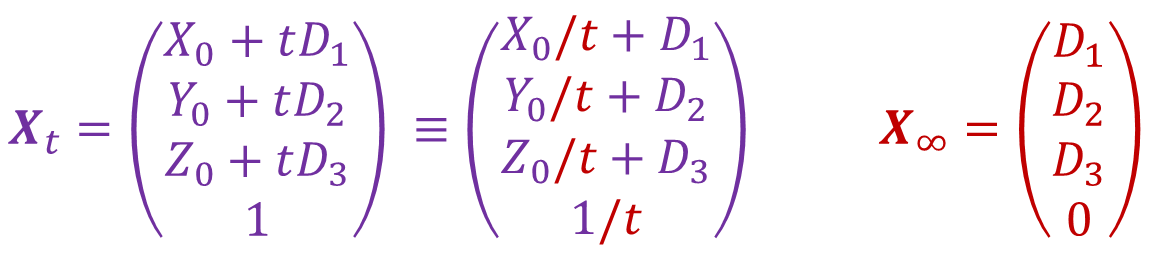

Consider the camera projection matrix:
$$P = \begin{bmatrix}p_{11} & p_{12} & p_{13} & p_{14} \\ p_{21} & p_{22} & p_{23} & p_{24} \\ p_{31} & p_{32} & p_{33} & p_{34}\end{bmatrix}$$

Now consider a point along the $X$ direction. The location of such a point can be given as:
$$\begin{bmatrix}X/t \\ Y/t \\ Z/t \\ 1/t \end{bmatrix} = \begin{bmatrix}X \\ 0 \\ 0 \\ 1 \end{bmatrix}$$
At the vanishing point, the point is at infinity and hence $1/t = 0$. Therefore, the point is given by:
$$\begin{bmatrix}1 \\ 0 \\ 0 \\ 0 \end{bmatrix}$$

The projection of this point is given by:
$$\begin{bmatrix}p_{11} & p_{12} & p_{13} & p_{14} \\ p_{21} & p_{22} & p_{23} & p_{24} \\ p_{31} & p_{32} & p_{33} & p_{34}\end{bmatrix}\begin{bmatrix}1 \\ 0 \\ 0 \\ 0 \end{bmatrix} = \begin{bmatrix}p_{11} \\ p_{21} \\ p_{31} \end{bmatrix}$$

Therefore, each column of the projection matrix gives the vanishing point of the corresponding direction. The $4^{th}$ column gives the coordinates of the world origin because it is equivalent to setting $X = Y = Z = 0$.

Now consider $3$ orthogonal vanishing directions in the scene. These can be given by:
$$e_1 = \begin{pmatrix}1 \\ 0 \\ 0 \end{pmatrix} e_2 = \begin{pmatrix}0 \\ 1 \\ 0 \end{pmatrix} e_3 = \begin{pmatrix}0 \\ 0 \\ 1 \end{pmatrix}$$

The projection of these directions are given by:
$$v_i = KRe_i$$
Here translation is not considered because the vanishing points are at infinity.

By orthogonality, we have:

$$e_i^Te_j^T = 0$$

Therefore,

$$e_i^Te_j = v_i^TK^TR^TRK^Tv_j = 0$$

since R is a rotation matrix, $R^TR = I$

Therefore, 

$$v_i^TK^{-T}K^{-1}v_j = 0$$

$R$ is an extrinsic parameter and it has disappeared and we are left with just the camera calibraion matrix.

We require atleast 2 finite vanishing points in order to obtain the camera calibration matrix. Once that is know, we can obtain the $R$ matrix since,

$$K^{-1}v_i = Re_i$$

$$Re_1 = \begin{bmatrix}r_1 & r_2 & r_3\end{bmatrix} \begin{pmatrix}1 \\ 0 \\ 0 \end{pmatrix} = r_1$$

Therefore, 

$$r_i = K^{-1}v_i$$

There's no scale ambiguity since $||r_i||^2 = 1$

In [ ]:
def find_vanishing_points(image):
    """Find vanishing points from detected lines"""
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect lines using Hough transform
    edges = cv2.Canny(gray, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, 
                           minLineLength=100, maxLineGap=10)
    
    # Group lines by similar angles
    angles = []
    grouped_lines = []
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.arctan2(y2-y1, x2-x1)
        
        # Find or create group
        found_group = False
        for i, group_angle in enumerate(angles):
            if abs(angle - group_angle) < 0.1:  # Threshold for grouping
                grouped_lines[i].append(line)
                found_group = True
                break
                
        if not found_group:
            angles.append(angle)
            grouped_lines.append([line])
    
    # Calculate vanishing points for each group
    vanishing_points = []
    for group in grouped_lines:
        # Use least squares to find intersection point
        A = []
        b = []
        for line in group:
            x1, y1, x2, y2 = line[0]
            A.append([y2-y1, x1-x2])
            b.append(x1*y2 - x2*y1)
        
        vp = np.linalg.lstsq(A, b, rcond=None)[0]
        vanishing_points.append(vp)
        
    return np.array(vanishing_points)

def calculate_intrinsic_matrix(vanishing_points):
    """Calculate camera intrinsic matrix K using orthogonality constraints"""
    # Set up equations from orthogonal vanishing points
    A = []
    for i in range(len(vanishing_points)):
        for j in range(i+1, len(vanishing_points)):
            v1 = vanishing_points[i]
            v2 = vanishing_points[j]
            eq = [v1[0]*v2[0], v1[0]*v2[1] + v1[1]*v2[0], v1[1]*v2[1]]
            A.append(eq)
    
    A = np.array(A)
    
    # Solve system Aw = 0
    _, _, Vh = np.linalg.svd(A)
    w = Vh[-1]  # Take last row of Vh
    
    # Form matrix W and ensure positive definiteness
    W = np.array([[w[0], w[1]], 
                  [w[1], w[2]]])
    
    # Add small positive diagonal term for stability
    epsilon = 1e-10
    W += epsilon * np.eye(2)
    
    try:
        # Try Cholesky decomposition
        K = np.linalg.cholesky(np.linalg.inv(W))
    except np.linalg.LinAlgError:
        # If Cholesky fails, use eigendecomposition
        eigvals, eigvecs = np.linalg.eigh(W)
        # Ensure positive eigenvalues
        eigvals = np.maximum(eigvals, epsilon)
        W_pd = eigvecs @ np.diag(eigvals) @ eigvecs.T
        K = np.linalg.cholesky(np.linalg.inv(W_pd))
    
    # Add row/column for homogeneous coordinates
    K = np.vstack((K, [0, 0]))
    K = np.hstack((K, [[0], [0], [1]]))
    
    return K

def calculate_rotation_matrix(K, vanishing_points):
    """Calculate rotation matrix R from vanishing points and K"""
    R = np.zeros((3, 3))
    
    # First column is normalized first vanishing point in 3D
    v1 = np.append(vanishing_points[0], 1)
    r1 = np.linalg.inv(K) @ v1
    r1 = r1 / np.linalg.norm(r1)
    R[:, 0] = r1
    
    # Second column similar process
    v2 = np.append(vanishing_points[1], 1)
    r2 = np.linalg.inv(K) @ v2
    r2 = r2 / np.linalg.norm(r2)
    R[:, 1] = r2
    
    # Third column is cross product to ensure orthogonality
    R[:, 2] = np.cross(r1, r2)
    
    return R

def calculate_projection_matrix(image):
    """Calculate full camera projection matrix P"""
    # Find vanishing points
    vanishing_points = find_vanishing_points(image)
    
    # Calculate intrinsic matrix K
    K = calculate_intrinsic_matrix(vanishing_points)
    
    # Calculate rotation matrix R
    R = calculate_rotation_matrix(K, vanishing_points)
    
    # Assume camera center at origin for simplicity
    t = np.zeros((3, 1))
    
    # Form projection matrix P = K[R|t]
    P = K @ np.hstack((R, t))
    
    return P

image = cv2.imread('images/room.jpg')
P = calculate_projection_matrix(image)
print(P)

[[ 6.39240733e+01 -1.18769196e+03  1.37084739e+03  0.00000000e+00]
 [ 4.02077256e+02 -9.68825398e+02 -1.25159868e+03  0.00000000e+00]
 [ 9.99991712e-01  9.99882531e-01  4.15612657e-05  0.00000000e+00]]


### Epipolar Geometry

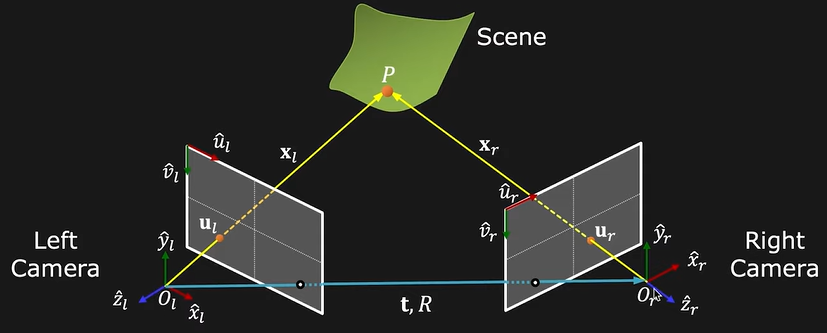

#### A few definitions


1. Baseline: The line joining the two camera centers. In the above image, $O_lO_r$ is the baseline.
2. Epipole: The point where the line joining the two camera centers intersects the image plane. In the above image, the points where the blue line meets the image planes are the epipoles. In other words, it is where the baseline meets the image plane. In the case where both cameras are parallel to each other, the epipoles lie at $\infty$.
3. Epipolar Plane: The plane containing the line joining the two camera centers and the point in the scene. In the above image, the plane $PO_lO_r$ is the epipolar plane. Each point in a scene has a unique epipolar plane.
4. Epipolar Line: The line joining the epipole and the projection of the point.

Fully labelled diagram:

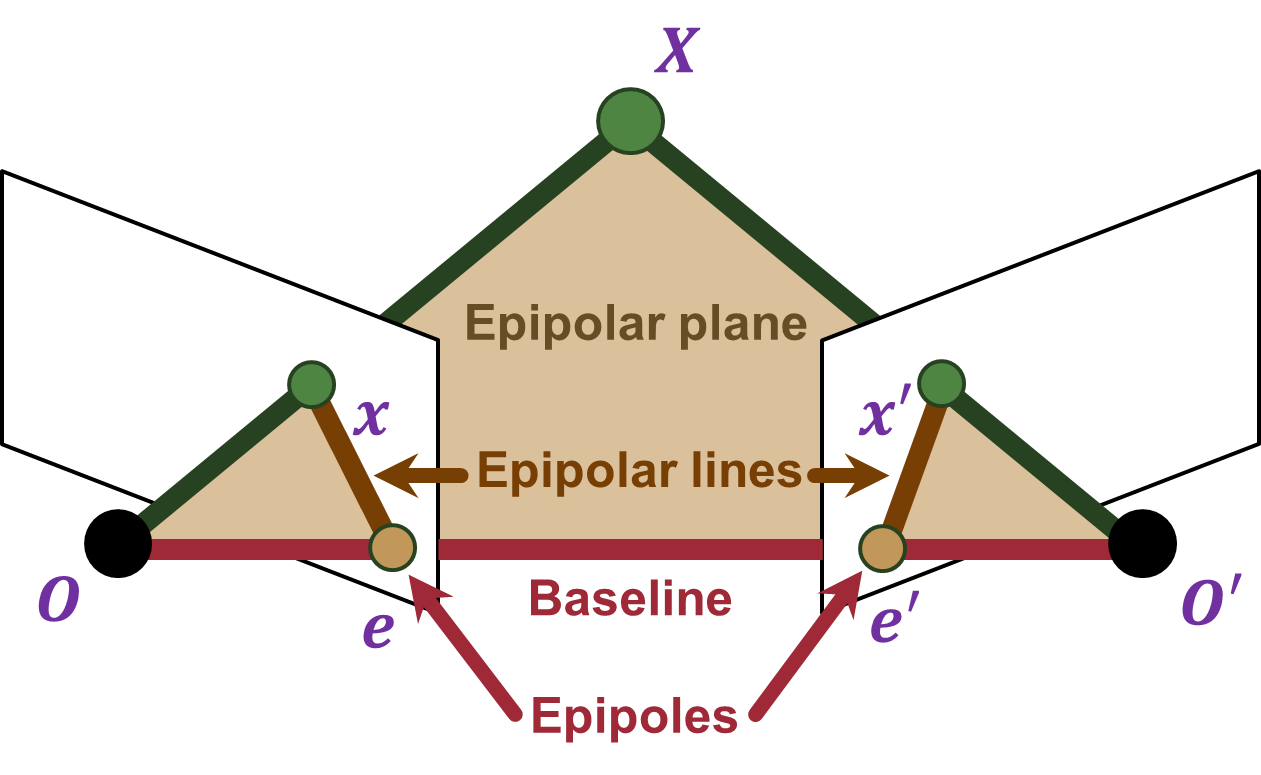

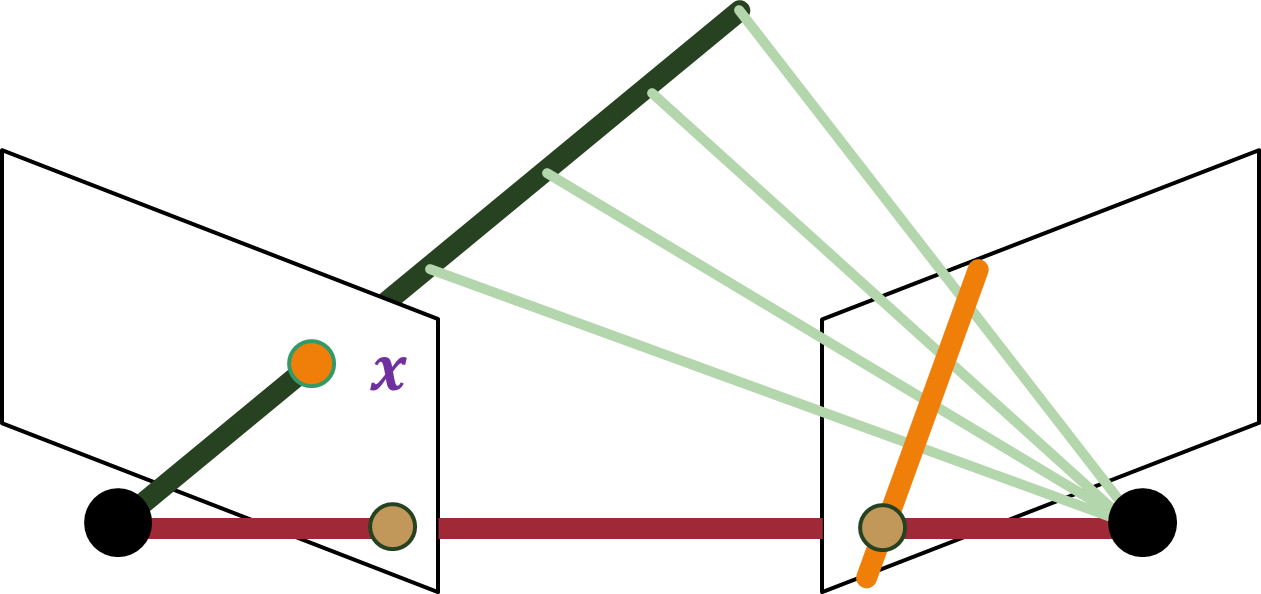

As shown above, any point along the direction will be along the eipiolar line in the other camera. Therefore, if a point is on 1 camera, it can be along the epipolar line in the other camera. This is called the epipolar constraint. However, the 2 lines drawn from the point in the image may not intersect.

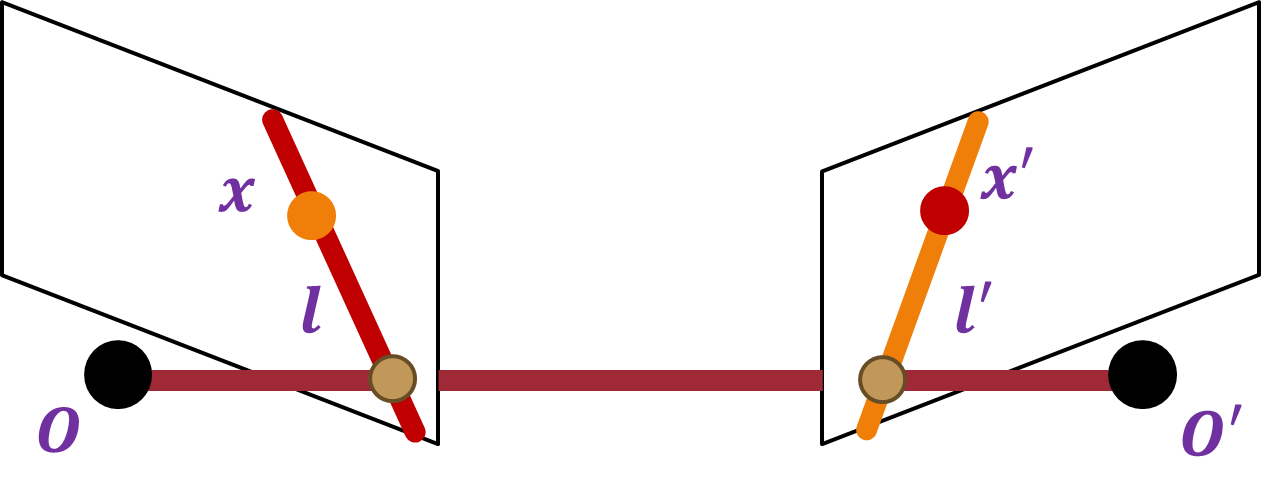

#### Motion perpendicular to image plane

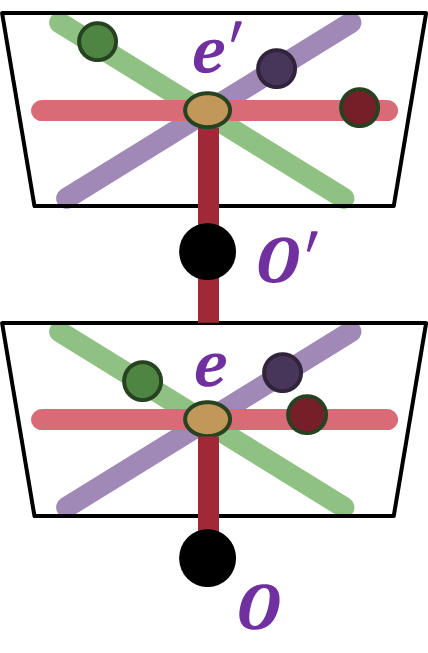

In motion analysis, the focus of expansion is the point in the image where motion vectors radiate outward, corresponding to the direction of motion of the observer or camera. This occurs when an object or the camera moves forward in a straight line towards or away from an object in the scene. When the camera is moving perpendicular to the image plane (forward or backward), the epipole coincides with the focus of expansion. This is because all motion vectors (optical flow) appear to radiate from the epipole as the camera moves directly towards or away from the scene.

#### Epipolar Constraint

Consider a point $x$ in one image. Where can we find the corresponding point $x'$ in the other image? The point must lie on the epipolar line. Similarly, if we have a point $x'$ in one image, the corresponding point $x$ in the other image must lie on the epipolar line. This is called the epipolar constraint.

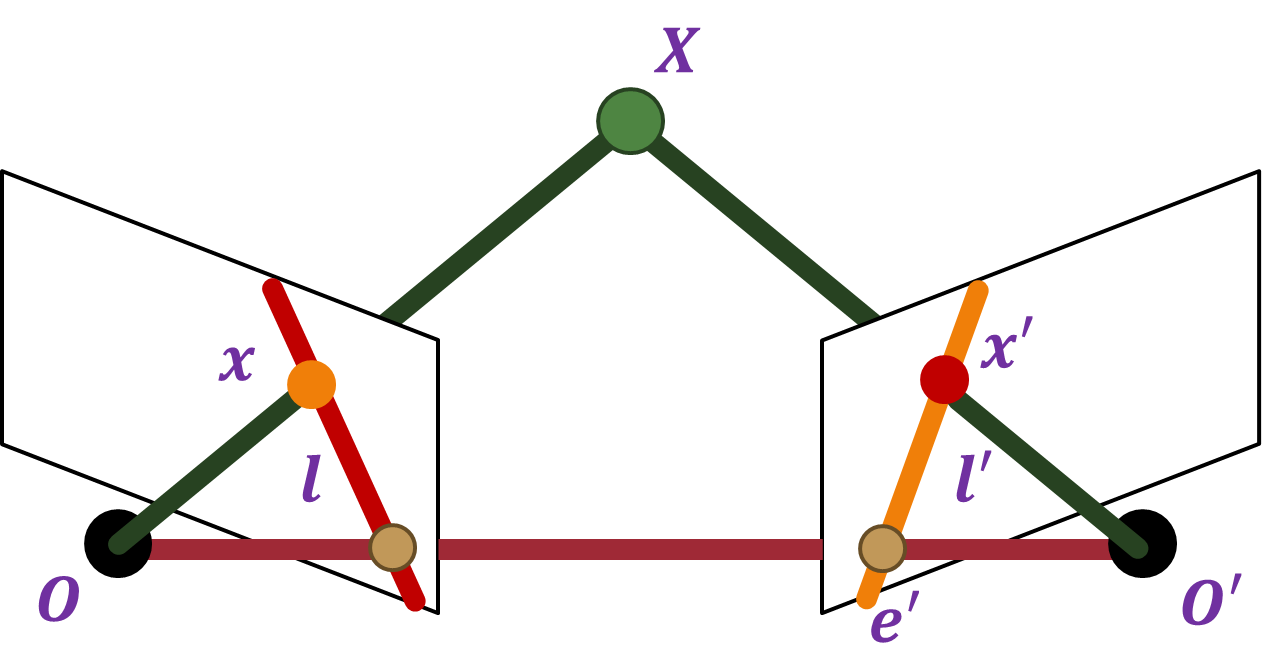


However, rays do not meet in general for a point in the scene. Additionally, even if the epipolar constraint is satisfied, we cannot conclude that the point is the same in both images.

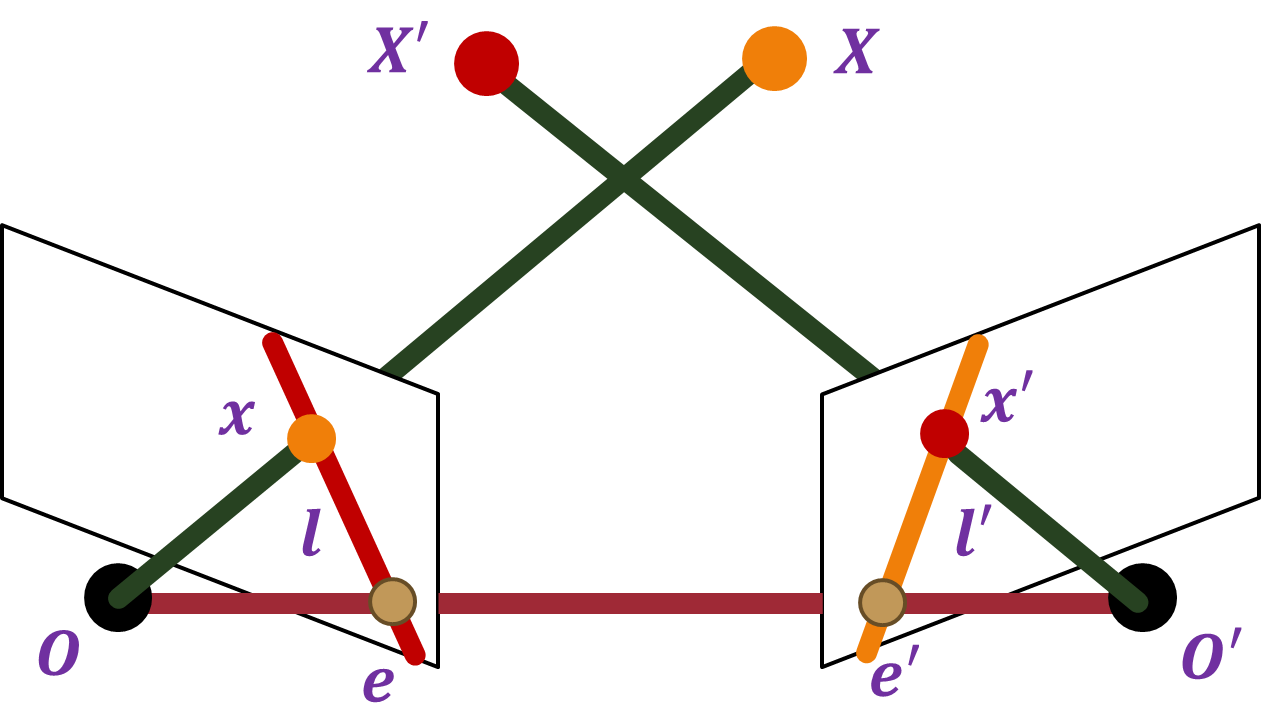

#### Essential Matrix

Consider the scenario as shown in the image below:

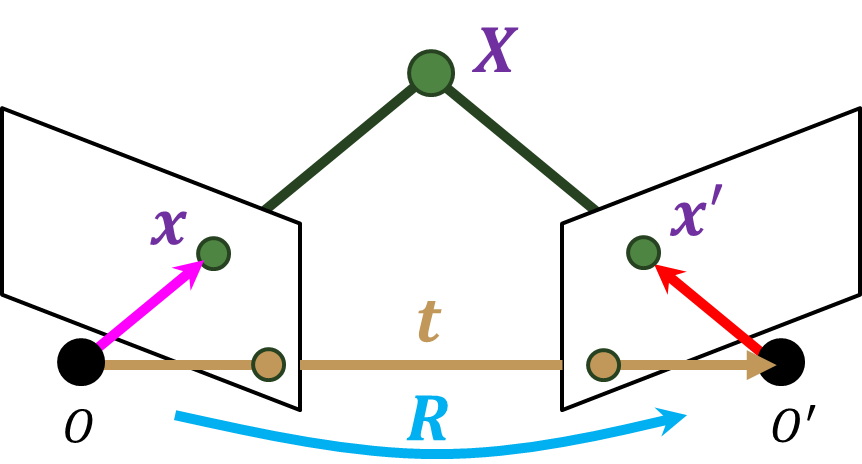


Here, we assume that the first camera is aligned with the world coordinates. Then the second camera is rotated by $R$ and translated by $t$ with respect to the first camera.

Projection matrices for each camera are given by:

$$P_1 = K [I | 0]$$

$$P_2 = K' [R | t]$$

The normalized image coordinates are coordinates that have been transformed from pixel-based image coordinates into a camera-centered coordinate system, typically on the image plane at unit focal length (i.e., a distance of 1 from the camera's optical center). This transformation essentially removes the effects of the camera's intrinsic parameters, making the coordinates independent of the camera's specific calibration (such as focal length, pixel aspect ratio, principal point, etc.). Normalized image coordinates are in a coordinate system where the camera is assumed to have a focal length of 1 and the principal point is at the origin.

The normalized image coordinates are given by:

$$x_{norm} = K^{-1}x_{pixel} = [I | 0]X$$

$$x'_{norm} = K'^{-1}x'_{pixel} = [R | t]X$$

Suppose $X = (x,1)^T$

This means that $x'_{norm} = Rx + t$. Therefore the vectors $x'$, $Rx$ and $t$ are linearly dependent.

We can write this linear dependence as:

$$x'.[t \times (Rx)] = 0$$

This is because $t \times (Rx)$ is perpendicular to $x'$ and hence the dot product is 0.

Replacing the cross product with a matrix multiplication, we get:

$$x'^T[t_{\times}]Rx = 0$$

$$x'^TEx= 0$$

where $E = [t_{\times}]R$ is the essential matrix.


Therefore, 
$$\begin{pmatrix}x' & y' & 1 \end{pmatrix} \begin{bmatrix} e_{11} & e_{12} & e_{13} \\ e_{21} & e_{22} & e_{23} \\ e_{31} & e_{32} & e_{33} \end{bmatrix} \begin{pmatrix} x \\ y \\ 1 \end{pmatrix} = 0$$

$Ex$ is the epipolar line in the right image corresponding to the point $x$ in the left image.

$$l' = Ex$$

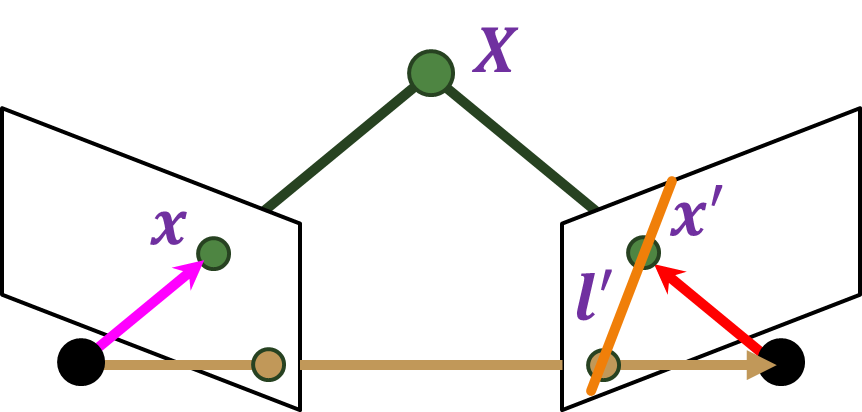

For a line given by $ax + by + c = 0$, $l^Tx = 0$ where $l = \begin{pmatrix} a & b & c \end{pmatrix}$ and $x = \begin{pmatrix} x & y & 1 \end{pmatrix}$

Since $x'^TEx = 0$, we can conslude that $x'^T$ is any point on the line $Ex$. Since $x'^T$ is on $l'$, we can arrive at the conclusion that $l' = Ex$

$$l = E^Tx' $$
$$ l' = Ex$$

$E$ is singular and has $5$ degrees of freedom.

#### Fundamental Matrix

Above, we considered the essential matrix which can be obtained when calibration matrices $K$ and $K'$ are known. What if they are not known?

Consider the epipolar constraint in terms of unknown cormalized coordinates:

$$x'^T_{norm}Ex_{norm} = 0$$

Here, $x_{norm} = K^{-1}x$ and $x'_{norm} = K'^{-1}x'$

Therefore, 

$$(K'^{-1}x')^TEK^{-1}x = 0$$

$$F = K'^{-T}EK^{-1}$$

Therefore,

$$x'^{T}Fx = 0$$

$$l = F^Tx' $$
$$ l' = Fx$$

$F$ is singular and has $7$ degrees of freedom.

#### Estimating the fundamental matrix

Consider correspondences $x = (x,y,1)^T$ and $x' = (x',y',1)^T$

From above we saw that, $x'^TFx = 0$

$$
\begin{pmatrix}
x'x, & x'y, & x', &y'x, & y'y, & y', &x, & y, & 1
\end{pmatrix}
\begin{pmatrix}
f_{11} \\ f_{12} \\ f_{13} \\
f_{21} \\ f_{22} \\ f_{23} \\
f_{31} \\ f_{32} \\ f_{33}
\end{pmatrix}

= 0$$

All such correspondences can be stacked

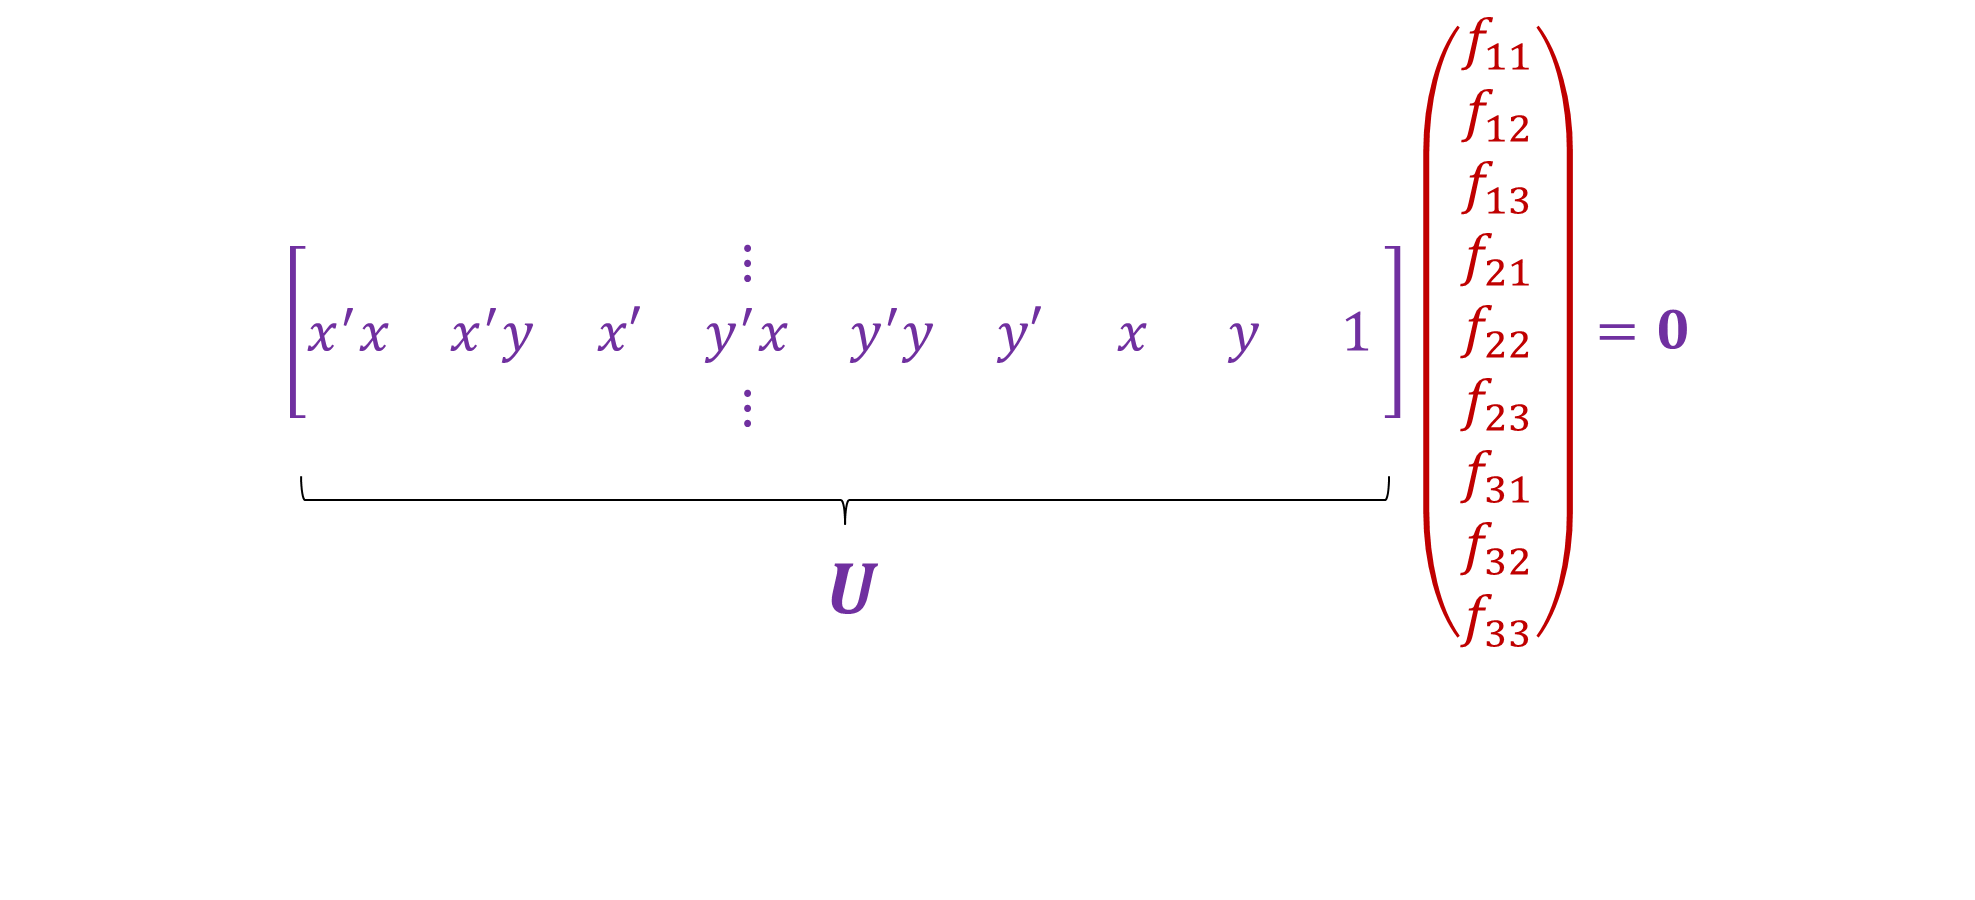

We need to find the mimimum value of $||Uf||_2^2$ such that $f = 1$ (normalized)

This is given by the eigrn vector of $U^TU$ with smallest eigenvalue


#### Enforcing the rank- constraint

Both the essential and fundamental matrices are rank 2 matrices. This means that the third singular value of these matrices should be zero.

Hoe do we enforce it? Take SVD of the initial estimate and set the third singular value to $0$. Then, reconstruct the matrix.


### Further analysis of the essntial matrix


Consider a vector normal to the epipolar plane. It can be given by the cross product of the vector joining the two camera centers and the vector joining the point in the scene and the camera center. That is,
$$n = t \times x_l$$
where $t$ is the position of the left camera in the right camera's frame and $x_l$ is the point in the left camera's frame.
The epipolar constraint is given by:
$$x_l . ( t \times x_l ) = 0$$
This can be expressed as:
$$\begin{bmatrix} x_l & y_l & z_l \end{bmatrix} \begin{bmatrix} t_yz_l - t_zy_l \\ t_zx_l - t_xz_l \\ t_xy_l - t_yx_l \end{bmatrix} = 0$$
Written in matrix form,
$$\begin{bmatrix} x_l & y_l & z_l \end{bmatrix} \begin{bmatrix} 0 & -t_z & t_y \\ t_z & 0 & -t_x \\ -t_y & t_x & 0 \end{bmatrix}\begin{bmatrix}x_l \\ y_l \\ z_l \end{bmatrix} = 0$$
$t$ is the position of the left camera in the right camera's frame and $R$ is the orientation of the left camera in the right camera's frame. Therefore,
$$x_l = Rx_r + t$$
Substituting this in the above equation we get,
$$\begin{bmatrix}
x_1 & y_1 & z_1
\end{bmatrix}
\left( \begin{bmatrix} 
0 & -t_z & t_y \\
t_z & 0 & -t_x \\
-t_y & t_x & 0
\end{bmatrix}
\begin{bmatrix}
r_{11} & r_{12} & r_{13} \\
r_{21} & r_{22} & r_{23} \\
r_{31} & r_{32} & r_{33}
\end{bmatrix}
\begin{bmatrix}
x_r \\
y_r \\
z_r
\end{bmatrix}
+
\begin{bmatrix}
0 & -t_z & t_y \\
t_z & 0 & -t_x \\
-t_y & t_x & 0
\end{bmatrix}
\begin{bmatrix}
t_x \\
t_y \\
t_z
\end{bmatrix}
=
\begin{bmatrix}
0 \\
0 \\
0
\end{bmatrix}\right)$$
 
 The last term is 0.
 Therefore,
$$\begin{bmatrix}
x_1 & y_1 & z_1
\end{bmatrix}
\left( \begin{bmatrix} 
0 & -t_z & t_y \\
t_z & 0 & -t_x \\
-t_y & t_x & 0
\end{bmatrix}
\begin{bmatrix}
r_{11} & r_{12} & r_{13} \\
r_{21} & r_{22} & r_{23} \\
r_{31} & r_{32} & r_{33}
\end{bmatrix}
\begin{bmatrix}
x_r \\
y_r \\
z_r
\end{bmatrix}
\right)$$
Multiplication of $t$ and $r$ (translation matrix and rotation matrix) gives us the essential matrix ($e$). Since $t$ is a skew symmetric matrix and $r$ is an orthogonal matrix, $e$ can be decomposed into $t$ and $r$ using SVD.